In [1]:
import os
import pickle
import numpy as np
import xml.etree.ElementTree as ET
import random
import svgwrite
from IPython.display import SVG, display
import tensorflow as tf
import time

def get_bounds(data, factor):
  min_x = 0
  max_x = 0
  min_y = 0
  max_y = 0
    
  abs_x = 0
  abs_y = 0
  for i in range(len(data)):
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    abs_x += x
    abs_y += y
    min_x = min(min_x, abs_x)
    min_y = min(min_y, abs_y)
    max_x = max(max_x, abs_x)
    max_y = max(max_y, abs_y)
    
  return (min_x, max_x, min_y, max_y)

# old version, where each path is entire stroke (smaller svg size, but have to keep same color)
def draw_strokes(data, factor=10, svg_filename = 'sample.svg'):
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
    
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))

  lift_pen = 1
    
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
    
  command = "m"

  for i in range(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "

  the_color = "black"
  stroke_width = 1

  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))

  dwg.save()
  display(SVG(dwg.tostring()))

def draw_strokes_eos_weighted(stroke, param, factor=10, svg_filename = 'sample_eos.svg'):
  c_data_eos = np.zeros((len(stroke), 3))
  for i in range(len(param)):
    c_data_eos[i, :] = (1-param[i][6][0])*225 # make color gray scale, darker = more likely to eos
  draw_strokes_custom_color(stroke, factor = factor, svg_filename = svg_filename, color_data = c_data_eos, stroke_width = 3)

def draw_strokes_random_color(stroke, factor=10, svg_filename = 'sample_random_color.svg', per_stroke_mode = True):
  c_data = np.array(np.random.rand(len(stroke), 3)*240, dtype=np.uint8)
  if per_stroke_mode:
    switch_color = False
    for i in range(len(stroke)):
      if switch_color == False and i > 0:
        c_data[i] = c_data[i-1]
      if stroke[i, 2] < 1: # same strike
        switch_color = False
      else:
        switch_color = True
  draw_strokes_custom_color(stroke, factor = factor, svg_filename = svg_filename, color_data = c_data, stroke_width = 2)

def draw_strokes_custom_color(data, factor=10, svg_filename = 'test.svg', color_data = None, stroke_width = 1):
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
    
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))

  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y

  for i in range(len(data)):

    x = float(data[i,0])/factor
    y = float(data[i,1])/factor

    prev_x = abs_x
    prev_y = abs_y

    abs_x += x
    abs_y += y

    if (lift_pen == 1):
      p = "M "+str(abs_x)+","+str(abs_y)+" "
    else:
      p = "M +"+str(prev_x)+","+str(prev_y)+" L "+str(abs_x)+","+str(abs_y)+" "

    lift_pen = data[i, 2]

    the_color = "black"

    if (color_data is not None):
      the_color = "rgb("+str(int(color_data[i, 0]))+","+str(int(color_data[i, 1]))+","+str(int(color_data[i, 2]))+")"

    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill(the_color))
  dwg.save()
  display(SVG(dwg.tostring()))

def draw_strokes_pdf(data, param, factor=10, svg_filename = 'sample_pdf.svg'):
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)

  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))

  abs_x = 25 - min_x 
  abs_y = 25 - min_y

  num_mixture = len(param[0][0])

  for i in range(len(data)):

    x = float(data[i,0])/factor
    y = float(data[i,1])/factor

    for k in range(num_mixture):
      pi = param[i][0][k]
      if pi > 0.01: # optimisation, ignore pi's less than 1% chance
        mu1 = param[i][1][k]
        mu2 = param[i][2][k]
        s1 = param[i][3][k]
        s2 = param[i][4][k]
        sigma = np.sqrt(s1*s2)
        dwg.add(dwg.circle(center=(abs_x+mu1*factor, abs_y+mu2*factor), r=int(sigma*factor)).fill('red', opacity=pi/(sigma*sigma*factor)))

    prev_x = abs_x
    prev_y = abs_y

    abs_x += x
    abs_y += y


  dwg.save()
  display(SVG(dwg.tostring()))



class DataLoader():
  def __init__(self, data_dir, batch_size=50, seq_length=300, scale_factor = 10, limit = 500):
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.seq_length = seq_length
    self.scale_factor = scale_factor # divide data by this factor
    self.limit = limit # removes large noisy gaps in the data

    data_file = os.path.join(self.data_dir, "strokes_training_data.cpkl")
    raw_data_dir = self.data_dir+"/lineStrokes"

    if not (os.path.exists(data_file)) :
        print("creating training data pkl file from raw source")
        self.preprocess(raw_data_dir, data_file)

    self.load_preprocessed(data_file)
    self.reset_batch_pointer()

  def preprocess(self, data_dir, data_file):
    # create data file from raw xml files from iam handwriting source.

    # build the list of xml files
    filelist = []
    # Set the directory you want to start from
    rootDir = data_dir
    for dirName, subdirList, fileList in os.walk(rootDir):
      #print('Found directory: %s' % dirName)
      for fname in fileList:
        #print('\t%s' % fname)
        filelist.append(dirName+"/"+fname)

    # function to read each individual xml file
    def getStrokes(filename):
      tree = ET.parse(filename)
      root = tree.getroot()

      result = []

      x_offset = 1e20
      y_offset = 1e20
      y_height = 0
      for i in range(1, 4):
        x_offset = min(x_offset, float(root[0][i].attrib['x']))
        y_offset = min(y_offset, float(root[0][i].attrib['y']))
        y_height = max(y_height, float(root[0][i].attrib['y']))
      y_height -= y_offset
      x_offset -= 100
      y_offset -= 100

      for stroke in root[1].findall('Stroke'):
        points = []
        for point in stroke.findall('Point'):
          points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
        result.append(points)

      return result

    # converts a list of arrays into a 2d numpy int16 array
    def convert_stroke_to_array(stroke):

      n_point = 0
      for i in range(len(stroke)):
        n_point += len(stroke[i])
      stroke_data = np.zeros((n_point, 3), dtype=np.int16)

      prev_x = 0
      prev_y = 0
      counter = 0

      for j in range(len(stroke)):
        for k in range(len(stroke[j])):
          stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
          stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
          prev_x = int(stroke[j][k][0])
          prev_y = int(stroke[j][k][1])
          stroke_data[counter, 2] = 0
          if (k == (len(stroke[j])-1)): # end of stroke
            stroke_data[counter, 2] = 1
          counter += 1
      return stroke_data

    # build stroke database of every xml file inside iam database
    strokes = []
    for i in range(len(filelist)):
      if (filelist[i][-3:] == 'xml'):
        print('processing '+filelist[i])
        strokes.append(convert_stroke_to_array(getStrokes(filelist[i])))

    f = open(data_file,"wb")
    pickle.dump(strokes, f, protocol=2)
    f.close()


  def load_preprocessed(self, data_file):
    f = open(data_file,"rb")
    self.ra_data = pickle.load(f)
    self.raw_data = self.ra_data[:50]
    f.close()

    # goes thru the list, and only keeps the text entries that have more than seq_length points
    self.data = []
    self.valid_data =[]
    counter = 0

    # every 1 in 20 (5%) will be used for validation data
    cur_data_counter = 0
    for data in self.raw_data:
      if len(data) > (self.seq_length+2):
        # removes large gaps from the data
        data = np.minimum(data, self.limit)
        data = np.maximum(data, -self.limit)
        data = np.array(data,dtype=np.float32)
        data[:,0:2] /= self.scale_factor
        cur_data_counter = cur_data_counter + 1
        if cur_data_counter % 20 == 0:
          self.valid_data.append(data)
        else:
          self.data.append(data)
          counter += int(len(data)/((self.seq_length+2))) # number of equiv batches this datapoint is worth

    print("train data: {}, valid data: {}".format(len(self.data), len(self.valid_data)))
    # minus 1, since we want the ydata to be a shifted version of x data
    self.num_batches = int(counter / self.batch_size)

  def validation_data(self):
    # returns validation data
    x_batch = []
    y_batch = []
    for i in range(self.batch_size):
      data = self.valid_data[i%len(self.valid_data)]
      idx = 0
      x_batch.append(np.copy(data[idx:idx+self.seq_length]))
      y_batch.append(np.copy(data[idx+1:idx+self.seq_length+1]))
    return x_batch, y_batch

  def next_batch(self):
    # returns a randomised, seq_length sized portion of the training data
    x_batch = []
    y_batch = []
    for i in range(self.batch_size):
      data = self.data[self.pointer]
      n_batch = int(len(data)/((self.seq_length+2))) # number of equiv batches this datapoint is worth
      idx = random.randint(0, len(data)-self.seq_length-2)
      x_batch.append(np.copy(data[idx:idx+self.seq_length]))
      y_batch.append(np.copy(data[idx+1:idx+self.seq_length+1]))
      if random.random() < (1.0/float(n_batch)): # adjust sampling probability.
        #if this is a long datapoint, sample this data more with higher probability
        self.tick_batch_pointer()
    return x_batch, y_batch

  def tick_batch_pointer(self):
    self.pointer += 1
    if (self.pointer >= len(self.data)):
      self.pointer = 0
  def reset_batch_pointer(self):
    self.pointer = 0

In [12]:
class FakeArgParse():
    def __init__(self):
        pass
args = FakeArgParse()

args.rnn_size = 256
args.num_layers = 4
args.batch_size = 25
args.seq_length = 500
args.num_epochs = 500
args.save_every = 50
args.model_dir = 'model_data'
args.grad_clip = 10
args.learning_rate = 0.0005
args.decay_rate = 0.99
args.num_mixture = 20
args.data_scale = 20

In [9]:
data_loader = DataLoader('./data', 25, 500, 20)
print (data_loader.num_batches)

train data: 34, valid data: 1
1


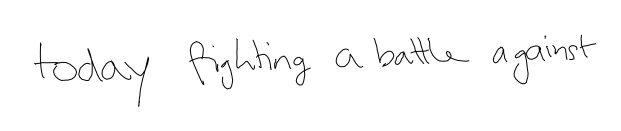

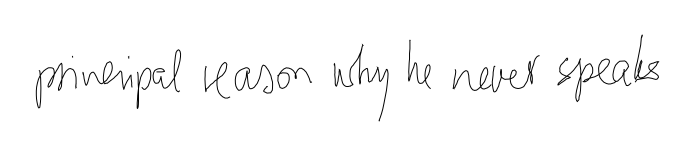

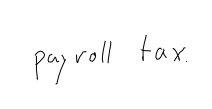

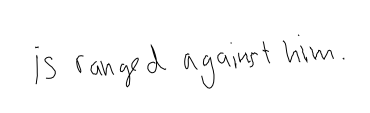

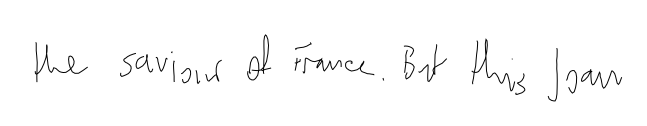

In [4]:
for i in range(5):
    draw_strokes(random.choice(data_loader.raw_data))

In [13]:
class Model():
    def __init__(self, args, bias=0, infer=False):
        self.args = args
        
        if infer:
            args.batch_size = 1
            args.seq_length = 1
            
        tf.reset_default_graph()
        self.input_x = tf.placeholder(tf.float32, [None,args.seq_length,3], name='x_batch')
        self.input_y = tf.placeholder(tf.float32, [None,args.seq_length,3], name='y_batch')
        N = tf.shape(self.input_x)[0]
        NOUT = 1 + args.num_mixture * 6
        W = tf.Variable(np.random.rand(args.rnn_size,NOUT),dtype=tf.float32)
        b = tf.Variable(np.zeros((1,NOUT)), dtype=tf.float32)
        
        def lstm_cell():
            return tf.contrib.rnn.BasicLSTMCell(args.rnn_size, state_is_tuple=True, reuse=tf.get_variable_scope().reuse)
        cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(args.num_layers)], state_is_tuple=True)
        self.cell = cell
        init_state = cell.zero_state(N, tf.float32)
        self.init_state = init_state
        states_series, current_state = tf.nn.dynamic_rnn(cell, self.input_x, initial_state=self.init_state)
        states_series = tf.reshape(states_series, [-1, args.rnn_size])
        self.state_out = tf.identity(current_state, name='state_out')
        output = tf.matmul(states_series, W) + b
        #[x1, x2, eos] = tf.split(axis=1, num_or_size_splits=3, value=flat_data)
        #eos = tf.sigmoid(eos)

        flat_target_data = tf.reshape(self.input_y,[-1, 3])
        [x1_data, x2_data, eos_data] = tf.split(axis=1, num_or_size_splits=3, value=flat_target_data)

        #x1_loss = tf.losses.mean_squared_error(x1_data, x1)
        #x2_loss = tf.losses.mean_squared_error(x2_data, x2)
        #eos_loss = tf.losses.softmax_cross_entropy(eos_data, eos)

        def tf_2d_normal(x1, x2, mu1, mu2, s1, s2, rho):
            # eq # 24 and 25 of http://arxiv.org/abs/1308.0850
            norm1 = tf.subtract(x1, mu1)
            norm2 = tf.subtract(x2, mu2)
            s1s2 = tf.multiply(s1, s2)
            z = tf.square(tf.div(norm1, s1))+tf.square(tf.div(norm2, s2))-2*tf.div(tf.multiply(rho, tf.multiply(norm1, norm2)), s1s2)
            negRho = 1-tf.square(rho)
            result = tf.exp(tf.div(-z,2*negRho))
            denom = 2*np.pi*tf.multiply(s1s2, tf.sqrt(negRho))
            result = tf.div(result, denom)
            return result

        def get_lossfunc(z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos, x1_data, x2_data, eos_data):
            result0 = tf_2d_normal(x1_data, x2_data, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr)
            # implementing eq # 26 of http://arxiv.org/abs/1308.0850
            epsilon = 1e-20
            result1 = tf.multiply(result0, z_pi)
            result1 = tf.reduce_sum(result1, 1, keep_dims=True)
            result1 = -tf.log(tf.maximum(result1, 1e-20)) # at the beginning, some errors are exactly zero.

            result2 = tf.multiply(z_eos, eos_data) + tf.multiply(1-z_eos, 1-eos_data)
            result2 = -tf.log(result2)

            result = result1 + result2
            return tf.reduce_sum(result)

        # below is where we need to do MDN splitting of distribution params
        def get_mixture_coef(output):
            # returns the tf slices containing mdn dist params
            # ie, eq 18 -> 23 of http://arxiv.org/abs/1308.0850
            z = output
            z_eos = z[:, 0:1]
            z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = tf.split(axis=1, num_or_size_splits=6, value=z[:, 1:])

            # process output z's into MDN paramters

            # end of stroke signal
            z_eos = tf.sigmoid(z_eos) # should be negated, but doesn't matter.
            
            b=bias # BIAS
            
            # softmax all the pi's:
            max_pi = tf.reduce_max(z_pi, 1, keep_dims=True)
            z_pi = tf.subtract(z_pi, max_pi)
            z_pi = tf.exp(z_pi*(1+b))
            normalize_pi = tf.reciprocal(tf.reduce_sum(z_pi, 1, keep_dims=True))
            z_pi = tf.multiply(normalize_pi, z_pi)

            # exponentiate the sigmas and also make corr between -1 and 1.
            z_sigma1 = tf.exp(z_sigma1-b)
            z_sigma2 = tf.exp(z_sigma2-b)
            z_corr = tf.tanh(z_corr)

            return [z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos]

        [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_eos] = get_mixture_coef(output)
        
        self.pi = o_pi
        self.mu1 = o_mu1
        self.mu2 = o_mu2
        self.sigma1 = o_sigma1
        self.sigma2 = o_sigma2
        self.corr = o_corr
        self.eos = o_eos

        lossfunc = get_lossfunc(o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_eos, x1_data, x2_data, eos_data)
        self.cost = lossfunc / (args.batch_size * args.seq_length)

        self.lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars), 10.)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_op = optimizer.apply_gradients(zip(grads, tvars))
    
    def sample(self, sess, num=1200):
        def get_pi_idx(x, pdf):
            N = pdf.size
            accumulate = 0
            for i in range(0, N):
                accumulate += pdf[i]
                if (accumulate >= x):
                    return i
            print('error with sampling ensemble')
            return -1

        def sample_gaussian_2d(mu1, mu2, s1, s2, rho):
            mean = [mu1, mu2]
            cov = [[s1*s1, rho*s1*s2], [rho*s1*s2, s2*s2]]
            x = np.random.multivariate_normal(mean, cov, 1)
            return x[0][0], x[0][1]

        prev_x = np.zeros((1, 1, 3), dtype=np.float32)
        prev_x[0, 0, 2] = 1 # initially, we want to see beginning of new stroke
        prev_state = sess.run(self.cell.zero_state(1, tf.float32))
        strokes = np.zeros((num, 3), dtype=np.float32)
        mixture_params = []

        for i in range(num):

            feed = {self.input_x: prev_x, self.init_state:prev_state}

            [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_eos, next_state] = sess.run([self.pi, self.mu1, self.mu2, self.sigma1, self.sigma2, self.corr, self.eos, self.state_out],feed)

            idx = get_pi_idx(random.random(), o_pi[0])

            eos = 1 if random.random() < o_eos[0][0] else 0

            next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx], o_sigma1[0][idx], o_sigma2[0][idx], o_corr[0][idx])

            strokes[i,:] = [next_x1, next_x2, eos]

            params = [o_pi[0], o_mu1[0], o_mu2[0], o_sigma1[0], o_sigma2[0], o_corr[0], o_eos[0]]
            mixture_params.append(params)

            prev_x = np.zeros((1, 1, 3), dtype=np.float32)
            prev_x[0][0] = np.array([next_x1, next_x2, eos], dtype=np.float32)
            
            prev_state = tuple(
                [tf.contrib.rnn.LSTMStateTuple(next_state[idx][0],next_state[idx][1])
                for idx in range(args.num_layers)]
            )

        strokes[:,0:2] *= self.args.data_scale
        return strokes, mixture_params

In [14]:
model = Model(args)

saver = tf.train.Saver(tf.global_variables())

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    #sess.run(tf.assign(model.lr, args.learning_rate))
    for e in range(args.num_epochs):
        sess.run(tf.assign(model.lr, args.learning_rate * (args.decay_rate ** e)))
        data_loader.reset_batch_pointer()
        
        #v_x, v_y = data_loader.validation_data()
        #valid_feed = {x_batch: v_x, y_batch: v_y}
        #for b in range(2):
        #    i = e * 1 + b
        for b in range(data_loader.num_batches):
            i = e * data_loader.num_batches + b
            start = time.time()
            x, y = data_loader.next_batch()
            feed = {model.input_x: x, model.input_y: y}
            train_loss, _ = sess.run([model.cost, model.train_op], feed)
            #valid_loss, _ = sess.run([total_loss, train_step], valid_feed)
            end = time.time()
            print(
                "{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}"  \
                .format(
                    i,
                    args.num_epochs * data_loader.num_batches,
                    e, 
                    train_loss, end - start))
            if (e * data_loader.num_batches + b) % args.save_every == 0 and ((e * data_loader.num_batches + b) > 0):
                    checkpoint_path = os.path.join(args.model_dir, 'model')
                    saver.save(sess, checkpoint_path)
                    print("model saved to {}".format(checkpoint_path))
                    with open('checkpoint', "w") as raw:
                        raw.write('model_checkpoint_path: "model"\nall_model_checkpoint_paths: "model"')

0/500 (epoch 0), train_loss = 4.582, time/batch = 11.109
1/500 (epoch 1), train_loss = 4.640, time/batch = 9.426
2/500 (epoch 2), train_loss = 4.636, time/batch = 10.525
3/500 (epoch 3), train_loss = 4.468, time/batch = 9.619


KeyboardInterrupt: 

In [23]:
with open('model_data/checkpoint', "w") as raw:
    raw.write('model_checkpoint_path: "model"\nall_model_checkpoint_paths: "model"')

In [76]:
tf.reset_default_graph()
model = Model(args, 0, True)
sess = tf.InteractiveSession()
saver = tf.train.Saver()

ckpt = tf.train.get_checkpoint_state('model_data')
print("loading model: ", ckpt.model_checkpoint_path)

saver.restore(sess, ckpt.model_checkpoint_path)

('loading model: ', u'model_data/model')
INFO:tensorflow:Restoring parameters from model_data/model


INFO:tensorflow:Restoring parameters from model_data/model


/home/gaurav/Desktop/assignment1/.env/lib/python2.7/site-packages/ipykernel/__main__.py:125: RuntimeWarning: covariance is not positive-semidefinite.


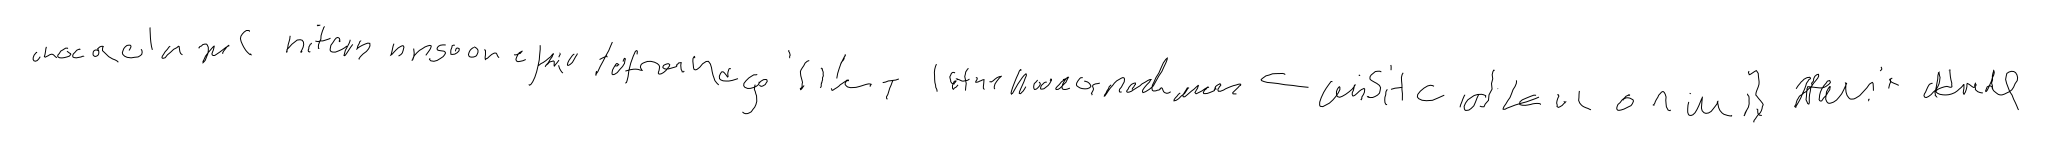

In [77]:
def sample_stroke():
    [strokes, params] = model.sample(sess, 2200)
    draw_strokes(strokes, factor=10, svg_filename = 'sample'+'.normal.svg')

sample_stroke()